In [173]:
import shap
import random
import itertools
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from evolutionary_algorithm import EvolutionaryAlgorithm # type: ignore

In [162]:
class EvolutionaryAlgorithm:
    def __init__(self, data):
        self.data = data
        # Clean numeric columns by removing commas and converting to float
        for column in self.data.columns:
            try:
                self.data[column] = self.data[column].str.replace(',', '').astype(float)
            except (AttributeError, ValueError):
                # If conversion fails, column might already be numeric or non-numeric
                continue

    def objective_function(self, individual):
        try:
            co2_emissions = float(individual['Energy Related CO2missions (Gigatonnes)'])
            electricity_generation = float(individual['Electricity Generation (Terawatt-hours)'])
            fitness = -co2_emissions + 0.5 * electricity_generation
            return fitness
        except (ValueError, KeyError) as e:
            print(f"Error in objective function: {e}")
            print(f"Individual data: {individual}")
            return float('-inf')  # Return worst possible fitness if there's an error

    def initialize_population(self, population_size):
        """
        Initialize a population of individuals (rows from the dataset).
        Each individual is a row of the dataset.
        """
        population = []
        for _ in range(population_size):
            individual = self.data.sample().squeeze().to_dict()  # Convert to dictionary for easier handling
            population.append(individual)
        return population

    def selection(self, population, fitness_scores):
        """
        Select the top half of the population based on fitness scores.
        """
        population_fitness = list(zip(fitness_scores, population))
        population_fitness.sort(reverse=True, key=lambda x: x[0])
        selected = [ind for score, ind in population_fitness[:len(population)//2]]
        return selected

    def crossover(self, parent1, parent2):
        """
        Perform crossover by mixing features of two parents to create a child.
        """
        child = {}
        for key in parent1.keys():
            if random.random() < 0.5:
                child[key] = parent1[key]
            else:
                child[key] = parent2[key]
        return child

    def mutate(self, individual, mutation_rate):
        """
        Mutate an individual's features slightly, to introduce variation.
        """
        mutated = individual.copy()
        for key in mutated.keys():
            if random.random() < mutation_rate:
                # Only mutate if the value is numeric
                try:
                    min_val = float(self.data[key].min())
                    max_val = float(self.data[key].max())
                    mutated[key] = random.uniform(min_val, max_val)
                except (ValueError, TypeError):
                    continue
        return mutated

    def run(self):
        population_size = 50
        generations = 100
        mutation_rate = 0.1

        # Initialize population
        population = self.initialize_population(population_size)
        
        best_fitness_history = []
        avg_fitness_history = []

        for generation in range(generations):
            # Evaluate fitness
            fitness_scores = [self.objective_function(individual) for individual in population]
            
            # Track statistics
            best_fitness = max(fitness_scores)
            avg_fitness = sum(fitness_scores) / len(fitness_scores)
            best_fitness_history.append(best_fitness)
            avg_fitness_history.append(avg_fitness)
            
            print(f"Generation {generation + 1}")
            print(f"Best Fitness: {best_fitness:.2f}")
            print(f"Average Fitness: {avg_fitness:.2f}")
            print("-" * 40)

            # Selection
            selected_population = self.selection(population, fitness_scores)

            # Crossover and mutation
            new_population = []
            while len(new_population) < population_size:
                parent1, parent2 = random.sample(selected_population, 2)
                child = self.crossover(parent1, parent2)
                child = self.mutate(child, mutation_rate)
                new_population.append(child)

            population = new_population

        print("\nEvolution complete!")
        print(f"Final Best Fitness: {max(fitness_scores):.2f}")
        return best_fitness_history, avg_fitness_history


In [112]:
# Load the final cleaned dataset
final_merged_df = pd.read_csv('scaled_merged_dataset.csv') 

In [113]:
# Initialize the evolutionary algorithm with the data
ea = EvolutionaryAlgorithm(data=final_merged_df)

In [115]:
# Run the evolutionary algorithm
best_fitness_history, avg_fitness_history = ea.run()

Generation 1
Best Fitness: 12810.75
Average Fitness: 10189.13
----------------------------------------
Generation 2
Best Fitness: 12812.91
Average Fitness: 11427.21
----------------------------------------
Generation 3
Best Fitness: 12812.91
Average Fitness: 12039.25
----------------------------------------
Generation 4
Best Fitness: 12812.44
Average Fitness: 12045.38
----------------------------------------
Generation 5
Best Fitness: 12812.44
Average Fitness: 12401.18
----------------------------------------
Generation 6
Best Fitness: 12812.60
Average Fitness: 12264.17
----------------------------------------
Generation 7
Best Fitness: 12812.75
Average Fitness: 12811.44
----------------------------------------
Generation 8
Best Fitness: 12812.76
Average Fitness: 12453.20
----------------------------------------
Generation 9
Best Fitness: 12812.76
Average Fitness: 12724.33
----------------------------------------
Generation 10
Best Fitness: 12813.61
Average Fitness: 12595.04
----------

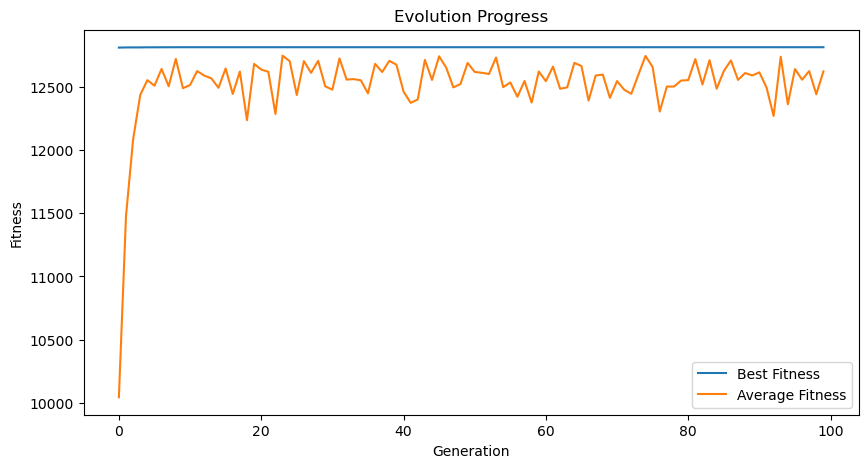

In [110]:
plt.figure(figsize=(10, 5))
plt.plot(best_fitness_history, label='Best Fitness')
plt.plot(avg_fitness_history, label='Average Fitness')
plt.xlabel('Generation')
plt.ylabel('Fitness')
plt.title('Evolution Progress')
plt.legend()
plt.show()

Calculating SHAP values...


  0%|          | 0/50 [00:00<?, ?it/s]


Generating SHAP summary plot...


/var/folders/1c/4kqr6dj16vj9y6y38ph10yq80000gn/T/ipykernel_39983/3390384169.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


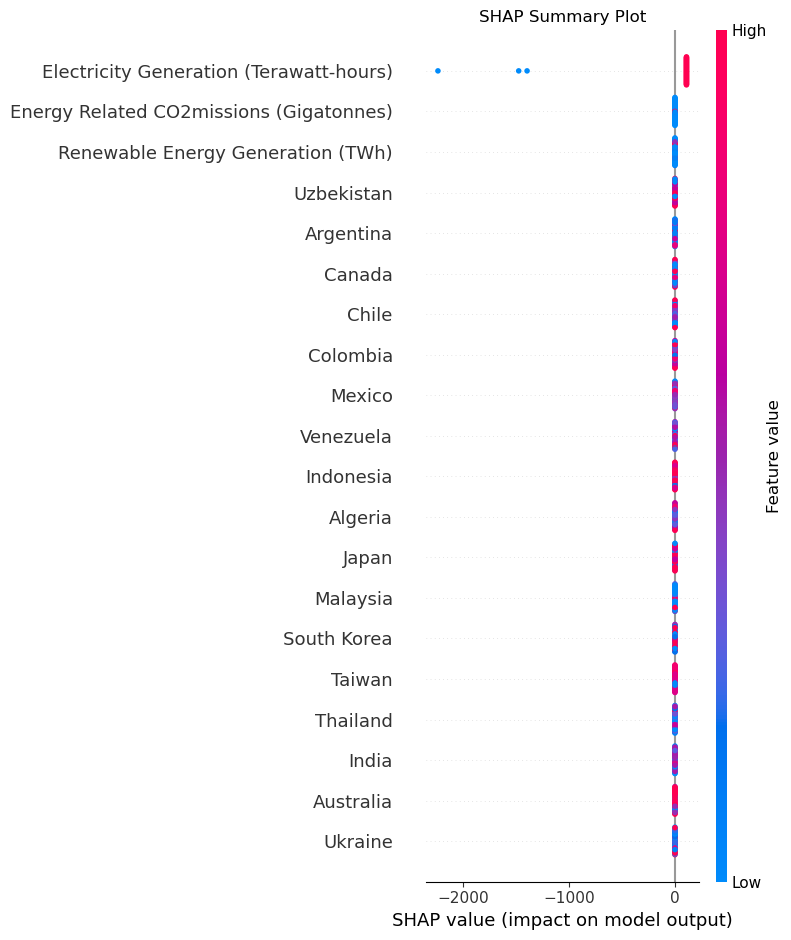


Generating feature importance plot...


/var/folders/1c/4kqr6dj16vj9y6y38ph10yq80000gn/T/ipykernel_39983/3390384169.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


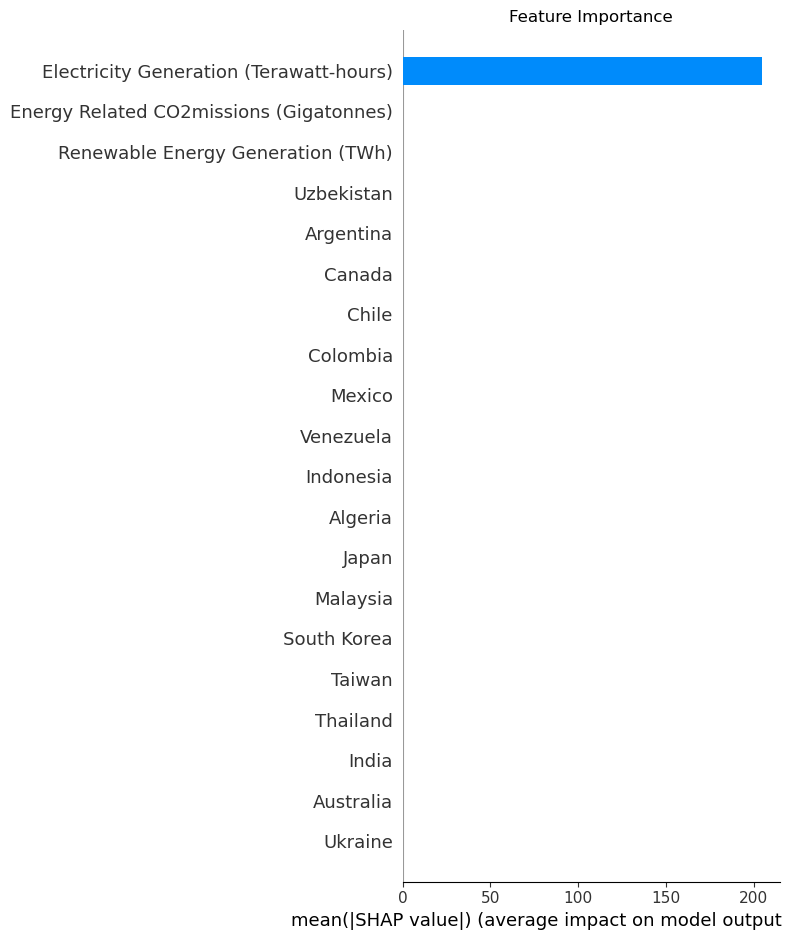


Top 5 Most Important Features:
                                    Feature  Importance
49  Electricity Generation (Terawatt-hours)  204.706418
45  Energy Related CO2missions (Gigatonnes)    0.189633
50      Hydroelectricity consumption in TWh    0.000000
57                         Geothermal (TWh)    0.000000
56                           Solar PV (TWh)    0.000000


In [143]:
def analyze_final_population(ea):
    # Convert final population to DataFrame and ensure numeric values
    final_population_df = pd.DataFrame(ea.final_population)
    
    # Convert all numeric columns to float
    for col in final_population_df.columns:
        try:
            final_population_df[col] = pd.to_numeric(final_population_df[col], errors='coerce')
        except:
            continue
    
    # Drop any non-numeric columns
    numeric_cols = final_population_df.select_dtypes(include=[np.number]).columns
    final_population_df = final_population_df[numeric_cols]
    
    # Create a wrapper for the fitness function that works with numpy arrays
    def fitness_model(X):
        # Convert numpy array back to dictionary format expected by objective_function
        results = []
        for i in range(len(X)):
            individual = {col: X[i, j] for j, col in enumerate(numeric_cols)}
            results.append(ea.objective_function(individual))
        return np.array(results)
    
    # Create background data for SHAP
    background_data = final_population_df.sample(min(100, len(final_population_df)))
    
    # Initialize SHAP explainer
    explainer = shap.KernelExplainer(fitness_model, background_data)
    
    # Calculate SHAP values for a subset of the final population
    sample_size = min(50, len(final_population_df))  # Limit sample size for computation
    sample_data = final_population_df.sample(sample_size)
    
    print("Calculating SHAP values...")
    shap_values = explainer.shap_values(sample_data)
    
    # Create plots
    print("\nGenerating SHAP summary plot...")
    shap.summary_plot(shap_values, sample_data, show=False)
    plt.title("SHAP Summary Plot")
    plt.tight_layout()
    plt.show()
    
    # Bar plot of feature importance
    print("\nGenerating feature importance plot...")
    shap.summary_plot(shap_values, sample_data, plot_type="bar", show=False)
    plt.title("Feature Importance")
    plt.tight_layout()
    plt.show()
    
    # Return the SHAP values and processed data for further analysis if needed
    return shap_values, sample_data

# Usage example:
import matplotlib.pyplot as plt

# After running your evolutionary algorithm:
shap_values, analyzed_data = analyze_final_population(ea)

# Print top 5 most important features based on mean absolute SHAP values
feature_importance = pd.DataFrame({
    'Feature': analyzed_data.columns,
    'Importance': np.abs(shap_values).mean(0)
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance.head())

In [177]:
class EvolutionaryAlgorithm:
    def __init__(self, data):
        self.data = data
        for column in self.data.columns:
            try:
                self.data[column] = self.data[column].str.replace(',', '').astype(float)
            except (AttributeError, ValueError):
                continue

    def objective_function(self, individual):
        try:
            # Core metrics
            co2_emissions = float(individual['Energy Related CO2missions (Gigatonnes)'])
            electricity_generation = float(individual['Electricity Generation (Terawatt-hours)'])
            
            # Renewable energy components
            hydro = float(individual.get('Hydroelectricity consumption in TWh', 0))
            solar = float(individual.get('Solar PV (TWh)', 0))
            geothermal = float(individual.get('Geothermal (TWh)', 0))
            
            # Calculate total renewable energy
            total_renewables = hydro + solar + geothermal
            
            # Calculate renewable percentage
            renewable_percentage = (total_renewables / electricity_generation) if electricity_generation > 0 else 0
            
            # Enhanced fitness function considering multiple factors
            fitness = (
                -2.0 * co2_emissions +  # Heavily penalize CO2 emissions
                0.5 * electricity_generation +  # Reward total generation
                1.0 * total_renewables +  # Reward renewable energy
                2.0 * renewable_percentage  # Extra reward for higher renewable percentage
            )
            
            return fitness
        except (ValueError, KeyError):
            return float('-inf')
        
    def initialize_population(self, population_size):
        population = []
        for _ in range(population_size):
            individual = self.data.sample().squeeze().to_dict()
            population.append(individual)
        return population

    def selection(self, population, fitness_scores):
        population_fitness = list(zip(fitness_scores, population))
        population_fitness.sort(reverse=True, key=lambda x: x[0])
        selected = [ind for score, ind in population_fitness[:len(population)//2]]
        return selected

    def crossover(self, parent1, parent2):
        child = {}
        for key in parent1.keys():
            child[key] = parent1[key] if random.random() < 0.5 else parent2[key]
        return child

    def mutate(self, individual, mutation_rate):
        mutated = individual.copy()
        for key in mutated.keys():
            if random.random() < mutation_rate:
                try:
                    min_val = float(self.data[key].min())
                    max_val = float(self.data[key].max())
                    mutated[key] = random.uniform(min_val, max_val)
                except (ValueError, TypeError):
                    continue
        return mutated

    def local_search(self, individual):
        """
        Slightly tweak the individual’s features to see if we can improve fitness.
        """
        improved_individual = individual.copy()
        mutation_rate = 0.02  # Small rate for local search tweaking
        return self.mutate(improved_individual, mutation_rate)

    def run(self, population_size=50, generations=100, mutation_rate=0.1, apply_local_search_every=10):
        population = self.initialize_population(population_size)
        
        best_fitness_history = []
        avg_fitness_history = []

        for generation in range(generations):
            fitness_scores = [self.objective_function(individual) for individual in population]
            
            best_fitness = max(fitness_scores)
            avg_fitness = sum(fitness_scores) / len(fitness_scores)
            best_fitness_history.append(best_fitness)
            avg_fitness_history.append(avg_fitness)
            
            print(f"Generation {generation + 1}")
            print(f"Best Fitness: {best_fitness:.2f}")
            print(f"Average Fitness: {avg_fitness:.2f}")
            print("-" * 40)

            selected_population = self.selection(population, fitness_scores)

            new_population = []
            while len(new_population) < population_size:
                parent1, parent2 = random.sample(selected_population, 2)
                child = self.crossover(parent1, parent2)
                child = self.mutate(child, mutation_rate)
                new_population.append(child)

            # Apply local search every few generations
            if (generation + 1) % apply_local_search_every == 0:
                print(f"Applying local search at generation {generation + 1}")
                best_individuals = selected_population[:len(selected_population)//4]  # Top 25%
                for i in range(len(best_individuals)):
                    best_individuals[i] = self.local_search(best_individuals[i])
                
                new_population.extend(best_individuals[:population_size - len(new_population)])  # Add them to new population

            population = new_population

        self.final_population = population

        print("\nEvolution complete!")
        print(f"Final Best Fitness: {max(fitness_scores):.2f}")
        return best_fitness_history, avg_fitness_history

Generation 1
Best Fitness: 12815.70
Average Fitness: 10245.30
----------------------------------------
Generation 2
Best Fitness: 12814.51
Average Fitness: 11348.11
----------------------------------------
Generation 3
Best Fitness: 12816.49
Average Fitness: 11789.96
----------------------------------------
Generation 4
Best Fitness: 12816.33
Average Fitness: 12026.95
----------------------------------------
Generation 5
Best Fitness: 12816.92
Average Fitness: 12118.97
----------------------------------------
Generation 6
Best Fitness: 12818.60
Average Fitness: 12197.13
----------------------------------------
Generation 7
Best Fitness: 12819.03
Average Fitness: 11965.35
----------------------------------------
Generation 8
Best Fitness: 12817.68
Average Fitness: 12473.10
----------------------------------------
Generation 9
Best Fitness: 12818.26
Average Fitness: 12366.59
----------------------------------------
Generation 10
Best Fitness: 12819.46
Average Fitness: 12655.47
----------

  0%|          | 0/50 [00:00<?, ?it/s]


Generating SHAP summary plot...


/var/folders/1c/4kqr6dj16vj9y6y38ph10yq80000gn/T/ipykernel_39983/3390384169.py:46: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


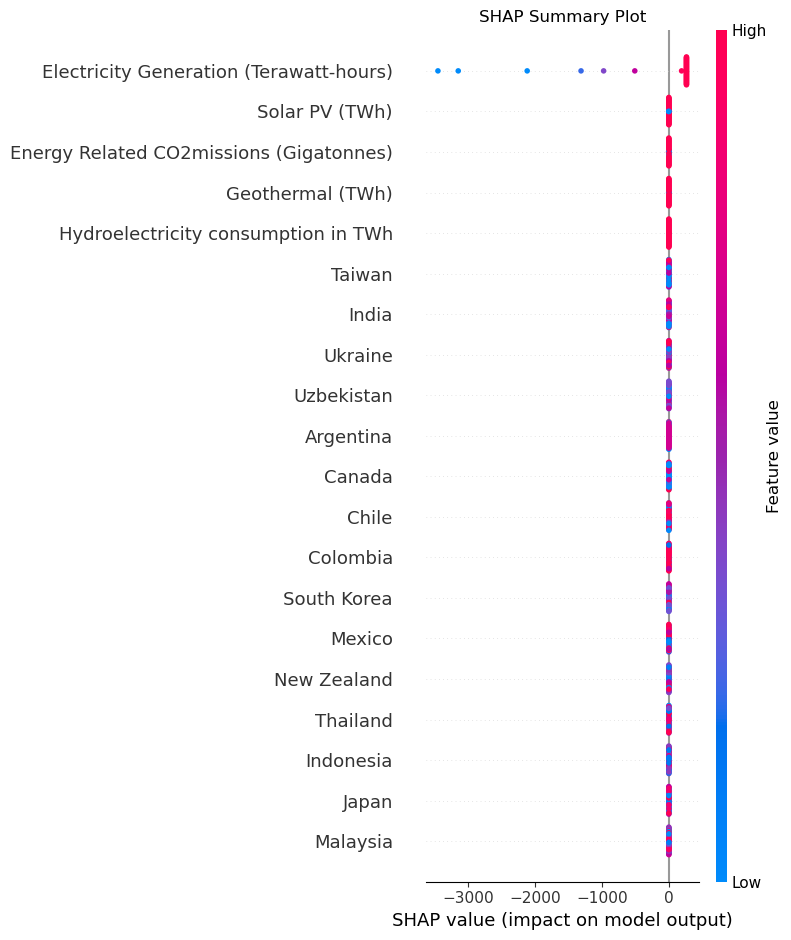


Generating feature importance plot...


/var/folders/1c/4kqr6dj16vj9y6y38ph10yq80000gn/T/ipykernel_39983/3390384169.py:53: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


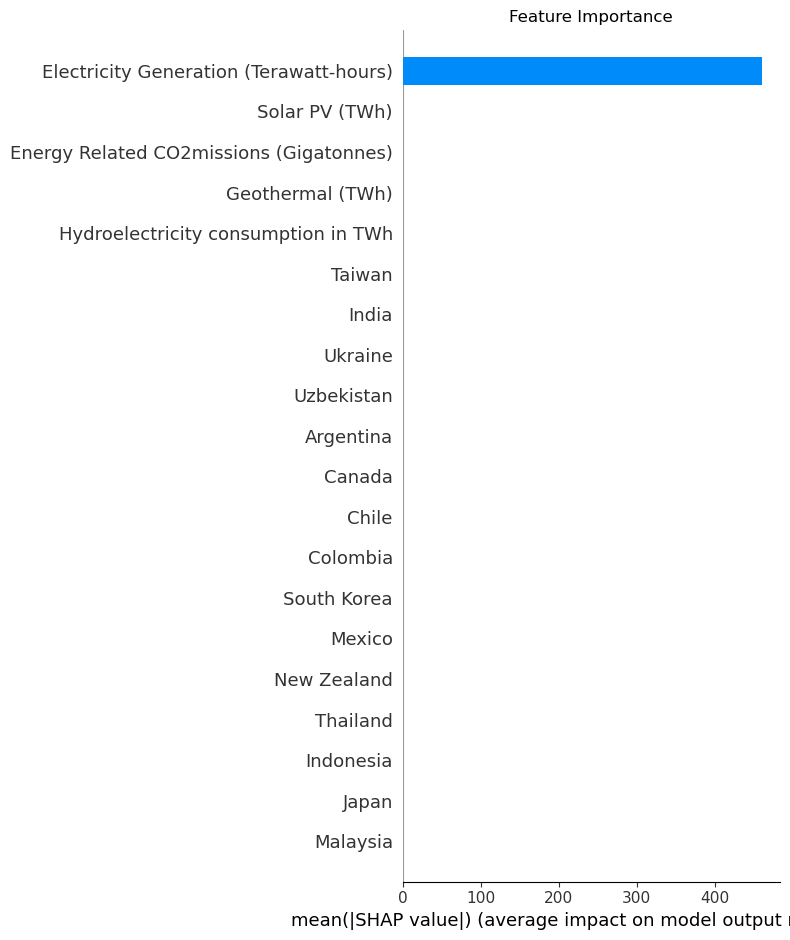

In [178]:
# Initialize with new objective function
ea_improved = EvolutionaryAlgorithm(data=final_merged_df)

# Run evolution
best_fitness_history, avg_fitness_history = ea_improved.run(
    population_size=50,
    generations=100,
    mutation_rate=0.1,
    apply_local_search_every=10
)

# Run SHAP analysis again
shap_values, analyzed_data = analyze_final_population(ea_improved)

In [179]:
# Print top 5 most important features based on mean absolute SHAP values
feature_importance = pd.DataFrame({
    'Feature': analyzed_data.columns,
    'Importance': np.abs(shap_values).mean(0)
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)

print("\nTop 5 Most Important Features:")
print(feature_importance.head())


Top 5 Most Important Features:
                                    Feature  Importance
49  Electricity Generation (Terawatt-hours)  460.150778
56                           Solar PV (TWh)    0.330603
45  Energy Related CO2missions (Gigatonnes)    0.219481
57                         Geothermal (TWh)    0.205765
50      Hydroelectricity consumption in TWh    0.041896
